In [1]:
import os

os.environ['DDE_BACKEND'] = 'tensorflow'
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

import numpy as np
import deepxde as dde

dde.config.set_default_float("float64")
dde.config.set_random_seed(42)
np.random.seed(42)

from deepxde.data import PDE
from deepxde.geometry import TimeDomain
from deepxde.icbc.initial_conditions import IC
from deepxde.icbc import PointSetBC
from deepxde.nn import FNN, PFNN
from deepxde.model import Model
from deepxde.callbacks import VariableValue, EarlyStopping
from deepxde.metrics import mean_squared_error, l2_relative_error
from scipy.integrate import solve_ivp
from matplotlib import pyplot as plt

from tensorflow.keras.optimizers.schedules import InverseTimeDecay

import sys
sys.path.append('../..')
from utils.custom_models import AdaptativeDataWeightModel

2025-11-21 10:18:20.596170: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Using backend: tensorflow
Other supported backends: tensorflow.compat.v1, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Enable just-in-time compilation with XLA.



Set the default float type to float64


In [2]:


def sir_system(t, compartments, gamma):
    S, I, R = compartments
    return [
        -beta_t(t) * S * I,
        beta_t(t) * S * I - gamma * I,
        gamma * I
    ]

In [3]:
t0, tf = 0, 50

beta1 = 0.2
beta0 = 0.4
omega = 0.44
phi = 0.0

beta_t = lambda t: beta1 * np.sin(omega * t + phi) + beta0

gamma = 0.1 
S0, I0, R0 = 0.99, 0.01, 0.0
beta_0 = beta_t(0)

In [4]:
sir_sol = solve_ivp(
    sir_system,
    [t0, tf],
    [S0, I0, R0],
    args=[gamma],
    dense_output=True
)

nop_data = 100
train_t = np.linspace(t0, tf, nop_data)
sir_data = sir_sol.sol(train_t).T

In [5]:
noise_std = 0.02
sir_data += np.random.normal(scale=noise_std, size=(nop_data, 3))
sir_data[sir_data < 0] = 0
sir_data[sir_data > 1] = 1

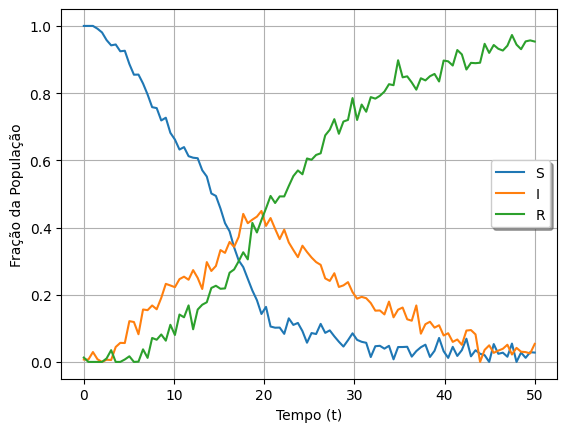

In [6]:
plt.plot(train_t, sir_data)
plt.legend(["S", "I", "R"], shadow=True)
plt.xlabel("Tempo (t)")
plt.ylabel("Fração da População")
plt.grid()
plt.savefig("../../images/rk-compartments-sen-beta-noisy-dfe.png")
plt.show()

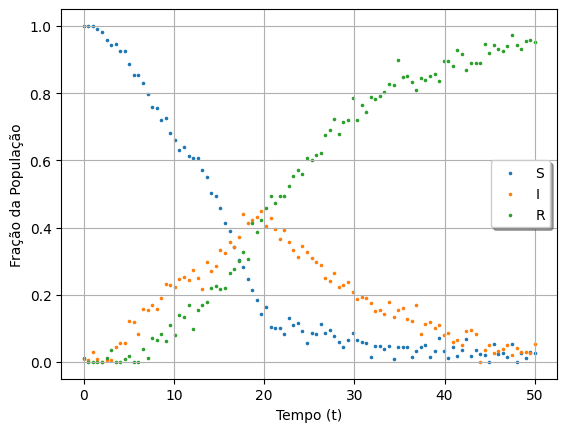

In [7]:
plt.scatter(train_t, sir_data[:, 0], s=2.5)
plt.scatter(train_t, sir_data[:, 1], s=2.5)
plt.scatter(train_t, sir_data[:, 2], s=2.5)
plt.legend(["S", "I", "R"], shadow=True)
plt.xlabel("Tempo (t)")
plt.ylabel("Fração da População")
plt.grid()
plt.savefig("../../images/rk-data-sen-beta-noisy-dfe.png")
plt.show()

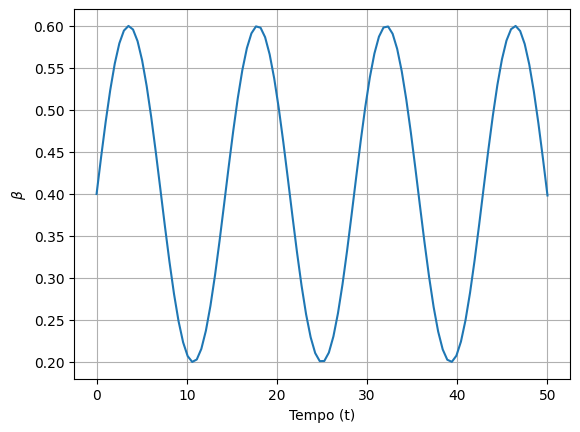

In [8]:

plt.plot(train_t, beta_t(train_t))
plt.xlabel("Tempo (t)")
plt.ylabel(r"$\beta$")
plt.grid()
plt.savefig("../../images/real-beta-sen-beta-noisy-dfe.png")
plt.show()

In [ ]:
timeinterval = TimeDomain(t0, tf)

def sir_residual(t, y):
    S, I, beta = y[:,0:1], y[:,1:2], y[:,2:3]

    dS_dt = dde.gradients.jacobian(y, t, i=0)
    dI_dt = dde.gradients.jacobian(y, t, i=1)
    
    return [
        dS_dt + beta * S * I,
        dI_dt - beta * S * I + gamma * I
    ]

# Tensorflow has an issue with lambdas...
def is_on_initial(_, on_initial): return on_initial
def S0_val(_): return S0
def I0_val(_): return I0

ic_S = IC(timeinterval, S0_val, is_on_initial, component=0)
ic_I = IC(timeinterval, I0_val, is_on_initial, component=1)

data_t = train_t.reshape(-1, 1)
data_S = PointSetBC(data_t, sir_data[:,0:1], component=0)
data_I = PointSetBC(data_t, sir_data[:,1:2], component=1)

ics = [ic_S, ic_I]
data_conds = [
    data_I 
] 

conditions = ics + data_conds

data = PDE(
    timeinterval, 
    sir_residual, 
    conditions,
    num_domain=128,
    num_boundary=2,
    num_test=32,
    anchors=data_t
)

n_hidden_layers = 4
hidden_layer_size = 50
topology = [1] + [hidden_layer_size] * n_hidden_layers + [3]
# activation = ["tanh"] * n_hidden_layers + ["sigmoid"]
activation = "tanh"
# activation = "ReLU"
initializer = "Glorot normal"
optimizer = "adam"
lr = 0.002

eq_w = 10
ic_w = 10
data_w = 1

loss_weights = [eq_w] * 2 + [ic_w] * len(ics) + [data_w] * len(data_conds)

# net = FNN(
#     topology, 
#     activation, 
#     initializer
# )

net = PFNN(
    topology, 
    activation, 
    initializer
)

n_equations = 2

model = AdaptativeDataWeightModel(data, net, n_physics=n_equations + len(ics), n_data=1)
# model = Model(data, net)

model.compile(
    optimizer, 
    lr,
    loss_weights=loss_weights
)


Compiling model...
'compile' took 0.009102 s



2025-11-21 10:18:26.640238: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1763731106.640988  716645 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1436 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


In [10]:
early_stopping = EarlyStopping(min_delta=1e-12, patience=10000)

losshistory, train_state = model.train(
    iterations=250000, 
    display_every=100,
    callbacks=[early_stopping]
)

# model.compile(
#     "L-BFGS", 
#     loss_weights=loss_weights
# )

# dde.optimizers.set_LBFGS_options(
#     # ftol=np.finfo(float).eps,
#     maxiter=25000,
#     ftol=1e-10,
#     gtol=1e-12
# )

# losshistory, train_state = model.train(
#     iterations=20000, 
#     display_every=100
# )

Training model...



2025-11-21 10:18:28.848639: I external/local_xla/xla/service/service.cc:163] XLA service 0x55f3f1269ae0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-11-21 10:18:28.848656: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2025-11-21 10:18:28.868769: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-21 10:18:28.962428: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002
I0000 00:00:1763731109.317955  716645 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Step      Train loss                                            Test loss                                             Test metric
0         [8.58e-02, 5.95e-02, 9.80e+00, 1.00e-03, 4.18e-02]    [1.53e-02, 2.67e-02, 9.80e+00, 1.00e-03, 4.18e-02]    []  
100       [4.55e-04, 5.06e-04, 1.07e-05, 5.22e-07, 3.01e-03]    [2.90e-04, 5.25e-04, 1.07e-05, 5.22e-07, 3.01e-03]    []  
200       [2.57e-04, 1.61e-04, 5.33e-09, 8.50e-08, 1.36e-03]    [1.56e-04, 1.49e-04, 5.33e-09, 8.50e-08, 1.36e-03]    []  
300       [1.69e-04, 1.15e-04, 6.89e-10, 1.49e-08, 1.23e-03]    [6.98e-05, 1.08e-04, 6.89e-10, 1.49e-08, 1.23e-03]    []  
400       [1.39e-04, 8.87e-05, 2.23e-10, 6.58e-09, 1.15e-03]    [4.71e-05, 8.31e-05, 2.23e-10, 6.58e-09, 1.15e-03]    []  
500       [1.17e-04, 7.09e-05, 8.85e-11, 4.60e-09, 1.10e-03]    [3.49e-05, 6.62e-05, 8.85e-11, 4.60e-09, 1.10e-03]    []  
600       [9.84e-05, 5.84e-05, 3.45e-11, 4.31e-09, 1.06e-03]    [2.60e-05, 5.42e-05, 3.45e-11, 4.31e-09, 1.06e-03]    []  
700      

In [11]:
model.save("../../models/sen-beta-noisy-dfe")

'../../models/sen-beta-noisy-dfe-24100.weights.h5'

In [12]:
dde.saveplot(
    losshistory, 
    train_state, 
    issave=True, 
    isplot=False,
    output_dir="../../losses", 
    loss_fname=f"loss-sen-beta-noisy-dfe",
    train_fname=f"train-sen-beta-noisy-dfe",
    test_fname=f"test-sen-beta-noisy-dfe")

Saving loss history to ../../losses/loss-sen-beta-noisy-dfe ...
Saving training data to ../../losses/train-sen-beta-noisy-dfe ...
Saving test data to ../../losses/test-sen-beta-noisy-dfe ...


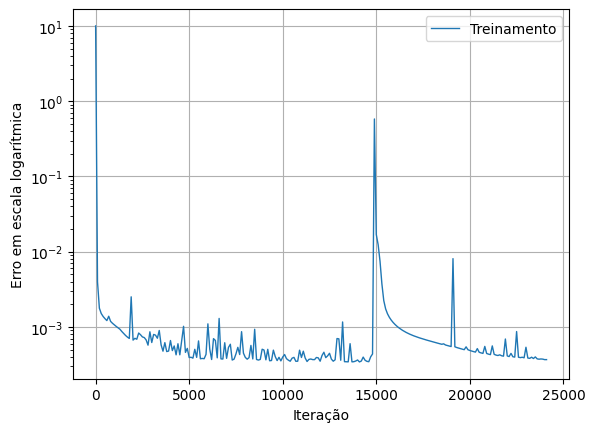

In [13]:
train = np.sum(losshistory.loss_train, axis=1)
test = np.sum(losshistory.loss_test, axis=1)

plt.semilogy(losshistory.steps, train, "-", label="Treinamento", linewidth=1)
# plt.semilogy(losshistory.steps, train, "o-", label="Treinamento", linewidth=2)
# plt.semilogy(losshistory.steps, test, "x-", label="Teste", linewidth=2)

plt.xlabel("Iteração")
plt.ylabel("Erro em escala logarítmica")

plt.legend()
plt.grid()
plt.savefig(f"../../images/loss-sen-beta-noisy-dfe.png")
plt.show()

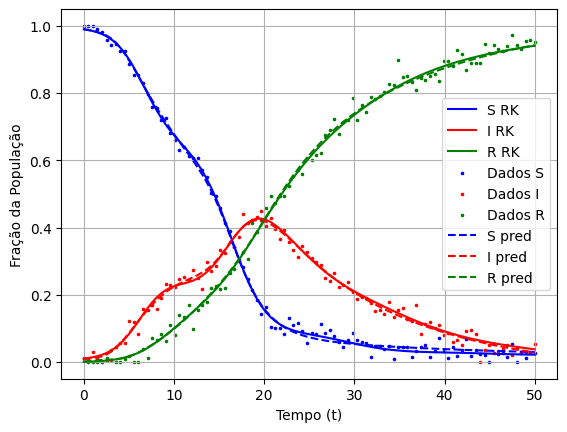

In [14]:
plt.rcParams['text.usetex'] = False
nop_test = 100

test_t = np.linspace(t0, tf, nop_test).reshape(-1, 1)
y_pred = model.predict(test_t)

S_pred, I_pred = y_pred[:, 0], y_pred[:, 1]
R_pred = 1 - S_pred - I_pred  

sir_test = sir_sol.sol(test_t.reshape(nop_test)).T

S_real = sir_test[:,0]
I_real = sir_test[:,1]
R_real = sir_test[:,2]

plt.plot(train_t, S_real, label="S RK", color="blue")
plt.plot(train_t, I_real, label="I RK", color="red")
plt.plot(train_t, R_real, label="R RK", color="green")

plt.scatter(train_t, sir_data[:,0], label="Dados S", color="blue", s=2.5)
plt.scatter(train_t, sir_data[:,1], label="Dados I", color="red", s=2.5)
plt.scatter(train_t, sir_data[:,2], label="Dados R", color="green", s=2.5)

plt.plot(test_t, S_pred, label="S pred", linestyle="--", color="blue")
plt.plot(test_t, I_pred, label="I pred", linestyle="--", color="red")
plt.plot(test_t, R_pred, label="R pred", linestyle="--", color="green")

plt.xlabel("Tempo (t)")
plt.ylabel("Fração da População")

plt.legend()
plt.grid()
plt.savefig("../../images/predicted-compartments-sen-beta-noisy-dfe.png")

plt.show()

[]

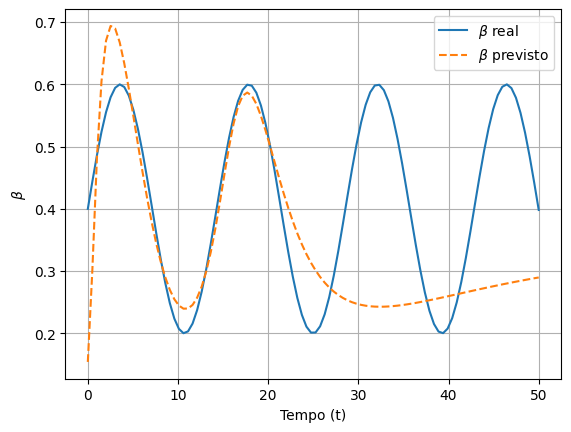

In [15]:
beta_pred = y_pred[:, 2]
beta_real = beta_t(test_t)
plt.plot(test_t, beta_real, label=r"$\beta$ real")
plt.plot(test_t, beta_pred, label=r"$\beta$ previsto", linestyle="--")
plt.xlabel("Tempo (t)")
plt.ylabel(r"$\beta$")
plt.legend()
plt.grid()
plt.savefig("../../images/predicted-beta-sen-beta-noisy-dfe.png")
plt.plot()

In [16]:
sir_test = sir_sol.sol(test_t.reshape(nop_test)).T

S_real = sir_test[:,0]
I_real = sir_test[:,1]
R_real = 1 - S_real - I_real

### MSE

In [17]:
mean_squared_error(S_real, S_pred)

5.1227502435612005e-05

In [18]:
mean_squared_error(I_real, I_pred)

2.5545782959885077e-05

In [19]:
mean_squared_error(R_real, R_pred)

1.7596727657026924e-05

In [20]:
mean_squared_error(beta_real, beta_pred)

0.024137741292460095

## L2

In [21]:
l2_relative_error(S_real, S_pred)

np.float64(0.015880407184543022)

In [22]:
l2_relative_error(I_real, I_pred)

np.float64(0.022554911570444106)

In [23]:
l2_relative_error(R_real, R_pred)

np.float64(0.006727479926942159)

In [24]:
l2_relative_error(beta_real, beta_pred)

np.float64(4.623905233597728)

## L-Infinity

In [25]:
np.max(np.abs(S_real - S_pred))

np.float64(0.011268785017763204)

In [26]:
np.max(np.abs(I_real - I_pred))

np.float64(0.010152095025792951)

In [27]:
np.max(np.abs(R_real - R_pred))

np.float64(0.0082373327304619)

In [28]:
np.max(np.abs(beta_real - beta_pred))

np.float64(0.49364951248399525)